In [14]:
import pandas as pd
import pickle
import os

#update the filename path, sheet name, column name and the num of rows to read
filename = "review_comments00.xlsx"
sheet_name = "Sheet1"
column_name = "comment"
num_rows = 73000
jabref_data = pd.read_excel(filename,sheet_name=sheet_name,nrows=num_rows)

#read the relevant column containing comments
complete_data = pd.DataFrame(jabref_data,columns=[column_name])
train_data = complete_data

print(train_data)
#train_data.to_csv('JustAfterRead.csv')

                                                 comment
0                  it is that easy to add inline comment
1             this looks like a copy-and-paste error :-)
2                                   needs berkeleydb too
3      iI had it actually in Patch Set 5 version, but...
4      HelpIndexer.hxx delivered twice? second should...
...                                                  ...
72995  There are still multiple issues with this subm...
72996  Regarding the first issue does that mean a new...
72997  I think there is a value in this specific Java...
72998             I have restored the deleted Java test.
72999  Thanks, but please restore `framework/JunitTes...

[73000 rows x 1 columns]


In [15]:
import re
import string

def clean_text_round1(text):
    text = re.sub(r'http\S+','', str(text)) #remove urls
    text = re.sub('[\(\)\[\]\{\}\/\-\+=…]', ' ', str(text)) #replace brackets with space
    text = re.sub('[‘’“”""``\'\'\._,\?<>@:;|!#&~…]', ' ', str(text))#get rid of punctuations & other special characters
    text = re.sub('[0-9]','',str(text)) #get rid of numbers
    
    #text = re.sub('\".*?\"', '', text) #replace code in " " e.g. "this code"
    #text = re.sub('\`.*?\`', '', text) #replace code in ` ` e.g. `this code`
    #text = re.sub('\'\S\'', '', text) #replace code in ' ' e.g. 'this code'
    #text = re.sub('\S+?\(\)', '', text) #replace code with '()' e.g. super()
    #text = re.sub('\w+?\.\S+', ' ', text) #replace code with '.' e.g. abc.def 
    #text = re.sub('\w*[A-Z]\w*[A-Z]\w*', '', text) #replace varibables like ThisVariableIsX

    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) #get rid of punctuation marks
    #text = re.sub('\w*\d\w*', '', text) #get rid of any words with numbers in them
    #text = re.sub('\[.*?\]', ' ', text) #get rid of text in square brackets
    return text

round1 = lambda x: clean_text_round1(x)
r1_data_clean = pd.DataFrame(train_data.comment.apply(round1))
#r1_data_clean.to_csv('clean_r1.csv')


In [16]:
# Apply a second round of cleaning
def clean_text_round2(text):
    text = text.lower()
    text = re.sub('\n', ' ', text) #get rid of \n
    text = re.sub('[^a-zA-Z_ ]',' ',text) #get rid of anything that is not alpha-numberic
    return text

def clean_text_round3(text):
    text = re.sub(r'\b\w{1,3}\b', '',text) # remove words shorter than 3 characters
    return text


round2 = lambda x: clean_text_round2(x)
r2_data_clean = pd.DataFrame(r1_data_clean.comment.apply(round2))
#r2_data_clean.to_csv('clean_r2.csv')
#print(r2_data_clean)


In [17]:
import pandas as pd
from collections import Counter
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from gensim.parsing.preprocessing import remove_stopwords
import pickle

#remove stop words_different approach
data_stop_list = pd.DataFrame([remove_stopwords(string) for string in r2_data_clean['comment']],columns=['comment'])

list_for_w2v = []
for row in data_stop_list["comment"]:
    row_list = list(row.split(" "))
    for word in row_list:
        list_for_w2v.append(word)

list_for_w2v = [list_for_w2v]
#print(list_for_w2v)
#data_stop_list.to_csv('afterStopWords.csv')

In [18]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem import PorterStemmer


w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

lemma = nltk.wordnet.WordNetLemmatizer()
stemmer = SnowballStemmer("english")
ps = PorterStemmer()

def lemmatize_this_text(text):
    return [lemma.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def stemm_this_text(text):
    return [ps.stem(w) for w in w_tokenizer.tokenize(text)]
    #return [stemmer.stem(w) for w in w_tokenizer.tokenize(text)]


data_lemma = pd.DataFrame(data_stop_list.comment.apply(lemmatize_this_text))
#data_stem = pd.DataFrame(data_stop_list.comment.apply(stemm_this_text))

data_lemma_merge = pd.DataFrame([TreebankWordDetokenizer().detokenize(data_lemma.comment[row]) for row in range(len(data_lemma))],columns=['comment'])
#data_lemma_merge = pd.DataFrame([TreebankWordDetokenizer().detokenize(data_stem.comment[row]) for row in range(len(data_stem))],columns=['comment'])


round3 = lambda x: clean_text_round3(x)
r3_data_clean = pd.DataFrame(data_lemma_merge.comment.apply(round3))

#print(r3_data_clean)
r3_data_clean.to_csv('data_cleaned.csv')


#Note: after pre-process. take the comments and cleaned data to excel, remove short comments and ensure that we have a review+taxonomy
#mapping to clean data(rows need to match). Then use the cleaned data for topic modelling.

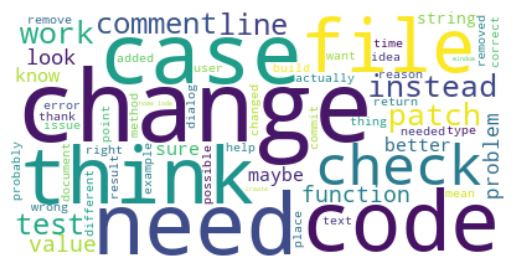

In [19]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=80, max_words=150, background_color="white").generate(' '.join(r3_data_clean['comment']))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('word cloud.png')